### Prologue
Prepare the notebook for inline plotting<br>
Load require libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [1]:
from IPython.display import Image
%matplotlib inline
%run rf_analysis_utils.py
%run nursery_dataprep.py

Utility code in the associated file performs the following steps:
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a function to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to pass batches of data to explore_forest(), split by correct/incorrect prediction: batch_analyse_model()
defines function to plot the mean path lengths from an object returned by explore_forest(): plot_mean_path_lengths()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to conv

The data objects are now saved and given a set of generic names ease of use.

In [2]:
# get the correct directory for saved objects
pickle_dir_store = open("pickle_dir.pickle", "rb")
pickle_dir = pickle.load(pickle_dir_store)
pickle_dir_store.close()

# helper function for pickling files
def pickle_path(filename):
    return(pickle_dir + '\\' + filename)

# load up the training set (required because of running from script into Jup Note)
encoder_store = open(pickle_path('encoder.pickle'), "rb")
encoder = pickle.load(encoder_store)
encoder_store.close()

X_train_enc_store = open(pickle_path('X_train_enc.pickle'), "rb")
X_train_enc = pickle.load(X_train_enc_store)
X_train_enc_store.close()

y_train_store = open(pickle_path('y_train.pickle'), "rb")
y_train = pickle.load(y_train_store)
y_train_store.close()

In [3]:
%run rf_analysis_modelprep.py

Parameter tuning (disabled)
Utility code in the associated file performs the following steps:
set random seed for the random forest
fetch the best parameters from model tuning results

Best OOB Cohen's Kappa during tuning: 0.9881
Best parameters: {'min_samples_leaf': 1, 'n_estimators': 1000, 'max_depth': 16}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model


### Random Forest Performance

Cohen's Kappa on unseen instances: 0.9883
Confusion matrix, without normalization
[[1308    0    0    0]
 [   0 1249   20    0]
 [   0    4 1210    0]
 [   0    7    0   90]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.98 0.02 0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.07 0.   0.93]]


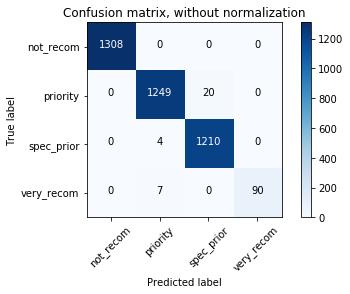

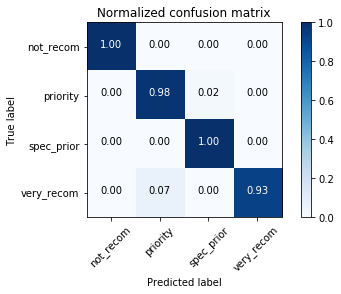

In [4]:
# test the model on unseen data
pred = enc_model.predict(X_test)
print("Cohen's Kappa on unseen instances: " "{:0.4f}".format(metrics.cohen_kappa_score(y_test, pred)))

# view the confusion matrix
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.figure()
# normalized confusion matrix
plot_confusion_matrix(cm
                      , classes=class_names
                      , normalize=True,
                      title='Normalized confusion matrix')


# Analysis of Random Forests by Decision Paths and Votes
This code uses the sci-kit learn object model to analyse a large tree ensemble trained over the dataset.

Currently only non-weighted trees are supported, so that rules out Boosted models, but a future version is intended to support weighted trees (weighted voting). 

Currently only categorical data is supported, so that rules out ExtraTrees, but a future version is intended to support ExtraTrees (random threshold selection).

This method relies on the stochastic process that selects the best split node at each split from a randomly selected restricted subspace.

# Part 1. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [5]:
# First instantiate new survey class with the RF model
f_survey = forest_surveyor(model = rf, features = onehot_features, prediction_model = enc_model)

In [6]:
########################################################################
### This takes a few minutes, so only run when an update is required ###
########################################################################

if True:
    
    batch = X_test
    labels = y_test

    correct_preds = enc_model.predict(batch) == labels
    incorrect_preds = enc_model.predict(batch) != labels
    
    if sum(correct_preds) > 0:
        X = batch[correct_preds.values]
        y = labels[correct_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_cor_stats = f_survey.forest_stats(np.unique(y))
        
    if sum(incorrect_preds) > 0:
        X = batch[incorrect_preds.values]
        y = labels[incorrect_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_incor_stats = f_survey.forest_stats(np.unique(y))
    
    tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "wb")
    pickle.dump(f_cor_stats, tt_correct_stats_store)
    tt_correct_stats_store.close()
    
    tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "wb")
    pickle.dump(f_incor_stats, tt_incorrect_stats_store)
    tt_incorrect_stats_store.close()

tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "rb")
tt_correct_stats = pickle.load(tt_correct_stats_store)
tt_correct_stats_store.close()

tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "rb")
tt_incorrect_stats = pickle.load(tt_incorrect_stats_store)
tt_incorrect_stats_store.close()

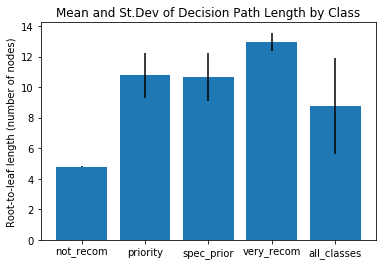

In [7]:
# comparing mean path lengths
plot_mean_path_lengths(tt_correct_stats, class_labels=class_names)

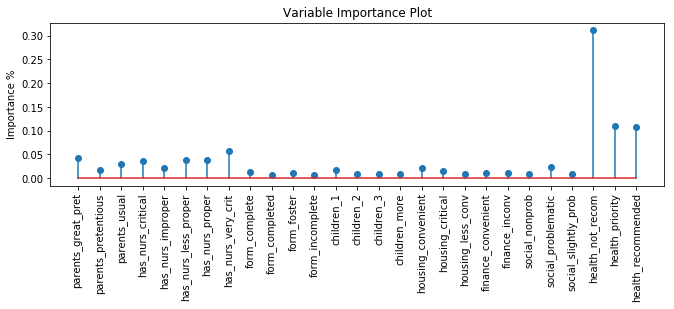

In [8]:
plot_varimp(rf, onehot_features)

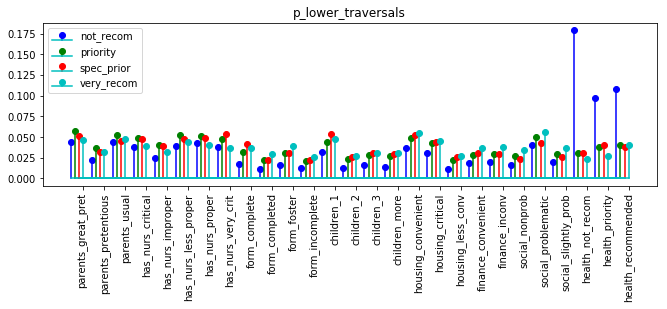

In [9]:
data = [[tt_correct_stats[k]['p_lower_traversals']] for k in tt_correct_stats.keys() if k != 'all_classes']
plot_feature_stats(data, class_names, 'p_lower_traversals', onehot_features)

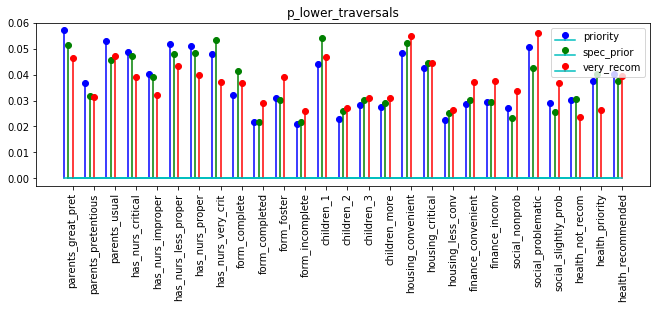

In [10]:
data = [[tt_correct_stats[k]['p_lower_traversals']] for k in tt_correct_stats.keys() if k!= 0 and k != 'all_classes']
plot_feature_stats(data, class_names[1:], 'p_lower_traversals', onehot_features)

In [ ]:
stat_impor_plot(importances = rf.feature_importances_, statistics = tt_correct_stats, label = 'all_classes')

In [ ]:
stat_impor_plot(importances = rf.feature_importances_, statistics = tt_correct_stats, label = 1)

In [ ]:
stat_impor_plot(importances = rf.feature_importances_, statistics = tt_correct_stats, label = 2)

In [ ]:
stat_impor_plot(importances = rf.feature_importances_, statistics = tt_correct_stats, label = 3)

The test set allows useful comparisons of correctly predicted and incorrectly predicted instances.

In [ ]:
resids, rank = cor_incor_plot(cor = tt_correct_stats, incor = tt_incorrect_stats, label = 1)

In [ ]:
log_ratio = log_ratio_plot(tt_correct_stats[1]['p_lower_traversals']
                           , tt_incorrect_stats[1]['p_lower_traversals']
                           , onehot_features)

In [ ]:
resids, rank = cor_incor_plot(cor = tt_correct_stats, incor = tt_incorrect_stats, label = 2)

In [ ]:
log_ratio = log_ratio_plot(tt_correct_stats[2]['p_lower_traversals']
                           , tt_incorrect_stats[2]['p_lower_traversals']
                           , onehot_features)

In [ ]:
resids, rank = cor_incor_plot(cor = tt_correct_stats, incor = tt_incorrect_stats, label = 3)

In [ ]:
log_ratio = log_ratio_plot(num = tt_correct_stats[3]['m_lower_traversals']
                            , num_err = tt_correct_stats[3]['se_lower_traversals']
                            , denom = tt_incorrect_stats[3]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[3]['se_lower_traversals']
                            , labels = onehot_features
)

### Comparing class profiles

In [ ]:
log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_lower_traversals'],
                           denom = tt_correct_stats[0]['m_lower_traversals'],
                           num_err = tt_correct_stats[1]['sd_lower_traversals'],
                           denom_err = tt_correct_stats[0]['sd_lower_traversals'],
                           labels = onehot_features)

log_ratio = log_ratio_plot(num = tt_correct_stats[3]['m_lower_traversals'],
                           denom = tt_correct_stats[1]['m_lower_traversals'],
                           num_err = tt_correct_stats[3]['sd_lower_traversals'],
                           denom_err = tt_correct_stats[1]['sd_lower_traversals'],
                           labels = onehot_features)

## Open Questions
There is a strong relationship between feature importance and feature depth, indicating that despite the randomness, feature importance exerts a pressure for a feature to be selected earlier.

Does it also mean a feature will be selected more frequently?

Is the relationship linear, or close to? Does feature depth add new information, compared to feature importance?
Feature depth is class specific. How can this be exploited?

Is this best suited to multi-class problems?

# Part 2. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [ ]:
first_n = 10

batch = X_test[0:first_n]
labels = y_test[0:first_n]

if True:
    '''
    tfp = forest_path(forest = rf
                    , feature_names = onehot_features
                    , instances = batch
                    , labels = labels
                    , feature_encoding = encoder
                    , by_tree = True)

    ifp = forest_path(forest = rf
                    , feature_names = onehot_features
                    , instances = batch
                    , labels = labels
                    , feature_encoding = encoder
                    , by_tree = False)
    '''
nfp = forest_path(forest = rf
                , feature_names = onehot_features
                , instances = batch
                , labels = None
                , feature_encoding = encoder
                , by_tree = False)

In [ ]:
# there is a bug in sklearn causing all the warnings. This should be fixed in next release.
paths = {}
sorted_fp = {}
for instance in range(first_n):
    paths[instance] = get_paths(nfp, instance, by_tree = False, which_trees='majority')
    print('Instance ' + str(instance) + ':    True Class = ' + 
        str(labels.values[instance]) + ' ' + 
          str(get_label(class_col, labels.values[instance])) + 
        '    Majority voting trees = ' + str(len(paths[instance])))

In [ ]:
# there is a bug in sklearn causing all the warnings. This should be fixed in next release.
instance = 5

# Collect useful data for instance
true_class = labels[instance:instance+1].values[0]
pred_probs = enc_model.predict_proba(batch[instance:instance + 1])[0]

# get the class codes produced by the model and the true class
true_class_code = get_label(class_col, true_class)

class_code_confs = np.argsort(pred_probs)[::-1] # descending order
pred_class_code = get_code(class_col, class_names[class_code_confs[0]])
second_class_code = get_code(class_col, class_names[class_code_confs[1]])

print('Test instance id: ' + str(instance))
print('True class: ' + str(true_class))
print('Pedicted Class Probabilities ')
for c, n, p in zip(class_names, range(len(class_names)), pred_probs):
    print(n, c, "{:0.4f}".format(p))

# Display instance row
nurs_id = batch[instance:instance + 1].index[0]
nursery[nurs_id:nurs_id + 1]

In [ ]:
# training data - could be a representative sample if original tr is too large or unavailable
training_data = X_train
training_labels = y_train

# MAJORITY
# generate a set of paths, sorting can be tuned
sorted_fp = get_sorted_fp(get_paths(nfp, instance, by_tree = False, which_trees='majority'),
                                 support = 0.2, max_itemset_size = 6, alpha = 0.0)
# create the rule accumulator
ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)

# run the profile
ra, model_votes = profile_instance(instance=instance
                                     , fp_object = nfp
                                     , rule_acc = ra
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 0.8)

# MINORITY
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(get_paths(nfp, instance, by_tree = False, which_trees='minority'),
                                 support = 0.2, max_itemset_size = 6, alpha = 0.0)

# create the rule accumulator
ra_min = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp_min)

# run the profile
ra_min, model_votes = profile_instance(instance=instance
                                     , fp_object = nfp
                                     , rule_acc = ra_min
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 0.8)

In [ ]:
ra.rule

In [ ]:
ra.prune_rule()
ra.pruned_rule

In [ ]:
p_count(training_labels.loc[apply_rule(ra.pruned_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
p_count(training_labels.loc[apply_rule([
 ('parents_usual', False, 0.5),
 ('social_problematic', True, 0.5),
 ('health_recommended', False, 0.5),
 ('form_complete', False, 0.5),
 ('has_nurs_improper', False, 0.5),
 ('housing_critical', True, 0.5),
 ('children_2', False, 0.5)
], encoder.transform(training_data), onehot_features)].values)

In [ ]:
ra.tight_rule

In [ ]:
p_count(training_labels.loc[apply_rule(ra.tight_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
ra3 = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)
for i in range(3):
    ra3.add_rule()
ra3.prune_rule()
ra3.pruned_rule

In [ ]:
p_count(training_labels.loc[apply_rule(ra3.pruned_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
ra_min.rule

In [ ]:
ra_min.prune_rule()
ra_min.pruned_rule

In [ ]:
ra_min.tight_rule

In [ ]:
p_count(training_labels.loc[apply_rule(ra_min.pruned_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
p_count(training_labels.loc[apply_rule(ra_min.tight_rule, encoder.transform(training_data), onehot_features)].values)

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [ ]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

In [ ]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
interp = interp.sort_values('very_recom', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

## LIME

In [ ]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

explainer = limtab.LimeTabularExplainer(training_data=np.array(X_train_enc.todense())
                                        , feature_names=onehot_features
                                        , training_labels=y_train
                                        , class_names=class_names
                                        , categorical_features=range(len(onehot_features))
                                        , categorical_names=onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
                                 , rf.predict_proba
                                 , top_labels=4)

In [ ]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

In [ ]:
print(pretty_print(ra3.pruned_rule))
print(pretty_print(ra.pruned_rule))
print('health ' + get_label('health', 2))
print('parents ' + get_label('parents', 2))
print('social ' + get_label('social', 0))
print('finance ' + get_label('finance', 0))
print('housing ' + get_label('housing', 2))
print('form ' + get_label('form', 0))
print('has_nurs ' + get_label('has_nurs', 1))
print('children ' + get_label('children', 1))

In [ ]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [ ]:
exp.show_in_notebook()

In [ ]:
# Priors for health feature
health_idx = features.index('health')
print(explainer.categorical_names[health_idx])
print(explainer.feature_frequencies[health_idx])

In [ ]:
import pyfpgrowth as fpg
patterns = fpg.find_frequent_patterns(paths_0, 200)
patterns

In [ ]:
[i for i, (f, t) in enumerate(zip(var_names, vars_types)) if t == 'nominal' and vars_dict[f]['class_col'] == False]

In [ ]:
tt_correct_stats[3]['n_node_traversals']# - tt_incorrect_stats[3]['n_node_traversals']

In [ ]:
[f for _,f in sorted(zip(rank,onehot_features))]

In [ ]:
lr = np.log(tt_correct_stats[1]['p_lower_traversals']/tt_incorrect_stats[1]['p_lower_traversals'])
np.where(lr == min(abs(lr)))[0][0]

In [ ]:
# create the rule accumulator
ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)

# run the profile
ra, model_votes = profile_covprecis(instance=instance, target_class=3
                                     , fp_object = nfp
                                     , rule_acc = ra
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 0.8)

In [ ]:
onehot_features